## IMPORT LIBRARIES

In [1]:
import math
import numpy as np
import pandas
import pathlib
import pickle
import matplotlib.pyplot as plt; import matplotlib.mlab as mlab;
#from sklearn import ensemble, linear_model, grid_search, cross_validation, preprocessing, metrics, datasets, feature_extraction;
from sklearn import ensemble, linear_model, model_selection, preprocessing, metrics, datasets, feature_extraction;
from scipy import stats;
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline 

## MAKE OUTPUR DIRECTORY OUTSIDE OF THE GIT REPO ON LOCAL DRIVE

In [2]:
dirpath = '..\\..\\outputs'
pathlib.Path(dirpath).mkdir(parents=True, exist_ok=True) 

## LOAD TRAIN AND TEST DATA FILES

In [10]:
train_engineered_file = dirpath + "\\train_data_engineered.pkl"
inFile = open(train_engineered_file, 'rb')
train_df = pickle.load(inFile)
inFile.close()

## Training data features and target
y_train = train_df["income"].values
X_train = train_df.drop("income", axis=1)
X_train.head()

,capital_gain,age,capital_loss,hours_per_week,education_num,Federal-gov,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,...,White,Female,Male,Canada,El-Salvador,Germany,Mexico,Philippines,Puerto-Rico,United-States
0,0.144467,0.044925,-0.219096,-0.078073,1.148160,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.148046,0.881237,-0.219096,-2.329956,1.148160,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.148046,-0.031103,-0.219096,-0.078073,-0.450707,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.148046,1.109322,-0.219096,-0.078073,-1.250140,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.148046,-0.107132,-0.219096,-0.078073,1.547877,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## FIT RANDOM FOREST MODEL

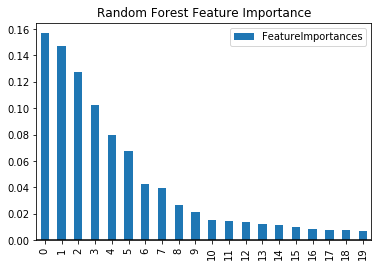

In [4]:
######### RANDOM FOREST MODEL WITH ONE SET OF PARAMETERS
classifier=RandomForestClassifier(n_estimators=25, min_samples_split=50, min_samples_leaf=10)
RFModel=classifier.fit(X_train, y_train)

######### RANDOM FOREST MODEL WITH CROSS VALIDATION OPTIMIZATION OF PARAMETER GRID
# Set grid for sampling
max_iter_search = n_iter_search = 59;

# Set Random Forest classifier learner
RfClassifier = ensemble.RandomForestClassifier(n_estimators=25, criterion='gini', max_depth=None, min_samples_split=20, min_samples_leaf=10, \
    min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=-1, \
    random_state=1234, verbose=0, warm_start=False, class_weight=None);

# Set param grid
param_grid = {
    'n_estimators': [25, 50, 100, 200],
    'min_samples_split': [10, 20, 30, 50],
    'min_samples_leaf': [2, 5, 10, 20]
}
grid_lengths = np.asarray([len(v) for v in param_grid.values()])
param_grid_size = 1
for l in grid_lengths:
    param_grid_size = param_grid_size * l

if param_grid_size < max_iter_search:
    n_iter_search = param_grid_size

# Run randomized search
random_search = model_selection.RandomizedSearchCV(RfClassifier, param_distributions=param_grid, n_iter=n_iter_search, cv=3)
CVRFModel = random_search.fit(X_train, y_train);

# Get and output feature importance, top 20 features
importances = list(CVRFModel.best_estimator_.feature_importances_)
top_indices = list(np.argsort(importances)[::-1])[0:20]
top_importances = [importances[i] for i in top_indices]
top_colNames = list(X_train.columns.values[top_indices])

df = pandas.DataFrame({
    'Features' : top_colNames,
    'FeatureImportances' : top_importances
})

plotpath = dirpath + '\\RandomForestFeatureImportancePlots.pdf'
df.plot(kind='bar', title="Random Forest Feature Importance"); 
plt.axhline(0, color='k');
plt.show
plt.savefig(plotpath)

featureImportanceOutputRF = dirpath + '\\featureImportanceOutputRF.csv'
df.to_csv(featureImportanceOutputRF)

########### PERSIST MODEL
model_file = dirpath + '\\CVRandomForestModel.pkl'
inFile = open(model_file, 'wb')
joblib.dump(CVRFModel, inFile) 
inFile.close()

## FIT ELASTIC NET MODEL WITH GRID SEARCH AND CV

In [5]:
######### ELASTICNET MODEL WITH CROSS VALIDATION OPTIMIZATION OF PARAMETER GRID
# Set grid for sampling
max_iter_search = n_iter_search = 59;

# Set param grid
alphas = []
for p in np.arange(-6,4,1):
    alphas.append(math.pow(2,p))

param_grid = {
    'l1_ratio': [0.99,  0.1 ,  0.25,  0.5 ,  0.75,  0.9 ,  0.01],
    'alpha': alphas
}
grid_lengths = np.asarray([len(v) for v in param_grid.values()])

param_grid_size = 1
for l in grid_lengths:
    param_grid_size = param_grid_size * l

if param_grid_size < max_iter_search:
    n_iter_search = param_grid_size

########### TRAIN ELASTICNET MODEL
# Define elastic net training function
SGDeNetLogistic = linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15)

# Run randomized search
random_search = model_selection.RandomizedSearchCV(SGDeNetLogistic, param_distributions=param_grid, n_iter=n_iter_search, cv=3)
CVModelEnet = random_search.fit(X_train, y_train);

########### PERSIST MODEL
model_file = dirpath + '\\CVElasticNetModel.pkl'
inFile = open(model_file, 'wb')
joblib.dump(CVModelEnet, inFile) 

#####################################################################################################
#####################################################################################################


C:\Users\ds1\AppData\local\AmlWorkbench\Python\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
